In [1]:
import os 
import random

import tensorflow as tf
import numpy as np
from PIL import Image

In [2]:
model_version = '7seg2912'

MODEL_FILE_PATH = f'../models/{model_version}.keras'
TFLITE_FILE_PATH = f'../models/{model_version}.tflite'
TFLITE_Q_FILE_PATH = f'../models/{model_version}q.tflite'

In [3]:
def get_image() -> tuple:
    digits_dir = '../training/digits_resized'
    
    image_path = random.choice(os.listdir(digits_dir))
    image_in = Image.open(os.path.join(digits_dir, image_path))
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image, [1, 32, 20, 3])
    
    correct_digit = int(image_path.split('_')[0])
    
    return correct_digit, img

# Standard model

In [4]:
model = tf.keras.models.load_model(MODEL_FILE_PATH)

In [5]:
_, img = get_image()
standard_times = %timeit -r 10 -n 25 -o model.predict(img, verbose=0)

41.5 ms ± 2.75 ms per loop (mean ± std. dev. of 10 runs, 25 loops each)


In [6]:
standard_times

<TimeitResult : 41.5 ms ± 2.75 ms per loop (mean ± std. dev. of 10 runs, 25 loops each)>

# TFLite model

In [7]:
# Load the TFLite model in TFLite Interpreter
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [8]:
correct_digit, img = get_image()
interpreter.set_tensor(input_details[0]['index'], img)

tflite_times = %timeit -r 10 -n 100 -o interpreter.invoke()

112 µs ± 8.42 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [9]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)
print(output_data.argmax())
print(correct_digit)

[[6.2321925e-13 6.6350314e-17 8.4506168e-22 1.0822694e-14 1.0208887e-08
  3.9116085e-08 9.7488061e-16 2.7673387e-17 1.8216386e-09 1.0000000e+00
  4.3004235e-15]]
9
9


# TLITE quantized model

In [10]:
# Load the TFLite model in TFLite Interpreter
interpreter_q = tf.lite.Interpreter(TFLITE_Q_FILE_PATH)
interpreter_q.allocate_tensors()

# Get input and output tensors.
input_details_q = interpreter_q.get_input_details()
output_details_q = interpreter_q.get_output_details()

In [11]:
correct_digit, img = get_image()
interpreter_q.set_tensor(input_details_q[0]['index'], img)

tflite_q_times = %timeit -r 10 -n 100 -o interpreter_q.invoke()

13.9 ms ± 296 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [12]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter_q.get_tensor(output_details_q[0]['index'])
print(output_data)
print(output_data.argmax())
print(correct_digit)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.99609375 0.         0.        ]]
8
8


# Plots

Text(0, 0.5, 'runtime in ms')

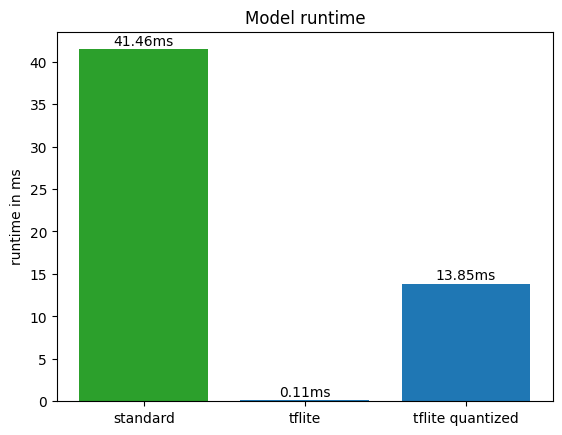

In [13]:
import matplotlib.pyplot as plt 

def add_labels(x, y):
    for i, y_i in enumerate(y):
        y_display = np.round(y_i, 2)
        
        plt.text(i, y_i + 0.5, f'{y_display}ms', ha = 'center')

models = ['standard', 'tflite', 'tflite quantized']
accuracies = [standard_times.average * 1000, tflite_times.average * 1000, tflite_q_times.average * 1000]

bar_colors = ['tab:green', 'tab:blue', 'tab:blue']

plt.title('Model runtime')
plt.bar(models, accuracies, color=bar_colors)

add_labels(models, accuracies)

plt.ylabel('runtime in ms')